In [22]:
import os
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from Bio import SeqIO, AlignIO

# import warnings
# warnings.filterwarnings('ignore')

# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(threshold=100)
torch.set_printoptions(edgeitems=100)

In [40]:
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22, 'B': 23}
AA_ALPHABETS = "ACDEFGHIKLMNPQRSTVWY-"

NUM_CLASSES = 21
GAP_INDEX = 20
GAP_THRESHOLD = 0.95
SIMILARITY_THRESHOLD = 0.9
SIMILARITY_THRESHOLDS =[0.2, 0.4, 0.6, 0.8]

In [86]:
def numeric_encode(seq, max_index=None):
    seq_numeric = np.array([aa1_to_index[aa] for aa in str(seq).upper().replace('.', '-')])
    if max_index is not None:
        seq_numeric[seq_numeric > max_index] = max_index
    return torch.from_numpy(seq_numeric)


def filter_gaps(index_seqs, gap_index, threshold=0.9):
    N = index_seqs.shape[0]
    gap_bools = torch.sum(index_seqs == gap_index, dim=0) > threshold * N
    # filtered_sequences = index_seqs[:, ~gap_bools]
    return gap_bools

def calculate_similarity_matrix(index_seqs, num_classes):
    N = len(index_seqs)
    L = len(index_seqs[0])
    C = num_classes
    # index_seqs = torch.tensor(index_seqs)
    one_hot_seqs = torch.nn.functional.one_hot(index_seqs, num_classes=C)
    one_hot_seqs[index_seqs > 19] = 0
    seq_lengths = (index_seqs <= 19).sum(dim=1).unsqueeze(-1)
    flat_one_hot_seqs = one_hot_seqs.view(N, L*C)
    similarity_matrix = torch.mm(flat_one_hot_seqs.float(),
                                 flat_one_hot_seqs.float().t()) / seq_lengths
    return similarity_matrix


def calculate_weights(similarity_matrix, similarity_thresholds):
    weights = {}
    for st in similarity_thresholds:
        w = 1.0 / similarity_matrix.gt(st).sum(dim=1).float()
        weights[str(st)] = w
    return weights


def filter_sequences(similarity_matrix, threshold=0.9):
    N = similarity_matrix.shape[0]
    keep_idx = []
    rm_idx = set()
    for i in range(0, N):
        if i not in rm_idx:
            keep_idx.append(i)
            sim_idx = torch.nonzero(similarity_matrix[i][i+1:] > threshold).flatten() + (i+1)
            rm_idx.update(set(sim_idx.tolist()))
    return keep_idx


test_index_seqs = torch.randint(0, 5, size=(15, 10))
test_similarity_matrix = calculate_similarity_matrix(test_index_seqs, 20)
filter_sequences(test_similarity_matrix, 0.5)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Pre-processing 

In [25]:
input_file = '/home/moon/projects/AgoAnalysis/msa/Argonaute_mmseqs_sampled.msa.fasta'

if input_file.endswith('.fasta.gz'):
    with gzip.open(input_file, 'rt') as handle:
        alignment = AlignIO.read(handle, "stockholm")
elif input_file.endswith('.fasta'):
    with open(input_file, 'r') as f:
        alignment = AlignIO.read(f, "fasta")
else:
    print('The input file needs to be *.fasta or *.fasta.gz')
    
encoded_sequences = {}
for record in alignment:
    encoded_sequences[record.id] = numeric_encode(record.seq, NUM_CLASSES-1)

In [87]:
index_seqs_raw = torch.stack(list(encoded_sequences.values()))
id_labels = [s.split('|')[1] for s in encoded_sequences.keys()]
print(f'Length of MSA: {len(index_seqs_raw[0])}')
gap_bools = filter_gaps(index_seqs_raw, GAP_INDEX, GAP_THRESHOLD)
index_seqs = index_seqs_raw[:, ~gap_bools]
print(f'Length of MSA after gap filtering: {len(index_seqs[0])}')
print(f'Number of seqs: {len(index_seqs)}')
similarity_matrix = calculate_similarity_matrix(index_seqs, NUM_CLASSES)
keep_indices = filter_sequences(similarity_matrix, SIMILARITY_THRESHOLD)
index_seqs_filtered = index_seqs[keep_indices]
id_labels_filtered = [id_labels[i] for i in keep_indices]
print(f'Number of seqs after similarity filtering: {len(index_seqs_filtered)}')
weights_dict = calculate_weights(similarity_matrix, SIMILARITY_THRESHOLDS)

Length of MSA: 8069
Length of MSA after gap filtering: 2184
Number of seqs: 5793
Number of seqs after similarity filtering: 2222


In [15]:
### Save or Load index_seqs

# torch_file = './data/index_seqs.pt'
# index_seqs = torch.load(torch_file)

# torch.save(index_seqs, torch_file)

In [42]:
def read_id2clade(path):
    id2clade = {}
    true_ids = ['AGO', 'PIWI', 'WAGO']
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            target, clade = line.rstrip().split('\t')
            if target not in id2clade.keys():
                id2clade[target] = clade if clade in true_ids else 'Other'
            else:
                if id2clade[target] in true_ids:
                    continue
                elif clade in true_ids:
                    id2clade[target] = clade
                else:
                    id2clade[target] = 'Other'
    return id2clade    

id2clade_path = '/home/moon/projects/AgoAnalysis/mmseqs/id2clade.tsv'
id2clade = read_id2clade(id2clade_path)

# Training

In [43]:
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm import tqdm

class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        """
        This method customizes the tqdm progress bar for validation.
        """
        # Create a simple progress bar with minimal information
        bar = tqdm(
            desc='Validation',
            total=None,  # Total will be unknown; the bar will show as a simple spinner
            leave=True,  # Leave the progress bar displayed after validation is complete
            position=0,
            disable=self.is_disabled,  # Disable if progress bars are globally disabled
            dynamic_ncols=True,  # Adjust to the terminal window width
            smoothing=0  # Disable smoothing for more responsive updates
        )
        return bar

In [44]:
from VAE_MSA import VAE
from ProteinDataModule import ProteinDataModule
from pytorch_lightning.loggers import TensorBoardLogger

dataset = index_seqs
indices = keep_indices
weights = None
L = dataset.shape[1]
C = NUM_CLASSES
N_EPOCHS = 15
device = torch.device("cuda")
log_name = 'Argonaute_Test'

h_params = {
    'batch_size': 32,
    'z_dim': 2,
    'lr': 1e-3,
    'dropout': 0.48,
    'beta': 0.05,
    'activation': 'LeakyReLU',
    'dim1': 1030,
    'dim2': 300,
    'is_annealing': False,
    'max_epochs': N_EPOCHS}

vae_model = VAE(input_length=L, num_classes=C, device=device, h_params=h_params).to(device)
pdm = ProteinDataModule(dataset, batch_size=h_params['batch_size'], weights=weights, indices=indices, seed_value=42)
logger = TensorBoardLogger(save_dir='./lightning_logs', name=log_name)
trainer = pl.Trainer(max_epochs=N_EPOCHS, callbacks=[CustomProgressBar()], logger=logger)
trainer.fit(model=vae_model, datamodule=pdm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | Sequential       | 47.6 M
1 | encoder_mu      | Linear           | 602   
2 | encoder_log_var | Linear           | 602   
3 | decoder         | Sequential       | 47.6 M
4 | loss_fn         | CrossEntropyLoss | 0     
-----------------------------------------------------
95.2 M    Trainable params
0         Non-trainable params
95.2 M    Total params
380.614   Total estimated model params size (MB)


Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

/home/moon/.pyenv/versions/3.11.7/envs/vae/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation DataLoader 0: 100%|████████████████████████| 11/11 [00:00<00:00, 304.97it/s]
`Trainer.fit` stopped: `max_epochs=15` reached.


In [45]:
trainer.test(model=vae_model, datamodule=pdm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                       | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1224298477172852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1224298477172852}]

# Hyperparameter Optimization

## Grid Search

In [13]:
from itertools import product

dataset = index_seqs
indices = keep_indices
weights = None
L = dataset.shape[1]
C = NUM_CLASSES
N_EPOCHS = 2
device = torch.device('cuda')

z_dim = 2
lr = 1e-3
batch_size = 64
dropouts = [0.1, 0.2, 0.5]
betas = [1e-3, 1e-2, 0.1, 0.3]
activations = ['LeakyReLU', 'ReLU', 'SELU', 'ELU']

for dropout, beta, activation in product(dropouts, betas, activations):
    h_params = {'z_dim': z_dim, 'lr': lr, 'batch_size': batch_size, 
                'dropout': dropout, 'beta': beta, 'activation': activation}
    print(h_params)
    vae_model = VAE(input_length=L, num_classes=C, device=device, h_params=h_params).to(device)
    pdm = ProteinDataModule(dataset, batch_size=h_params['batch_size'], weights=weights, 
                            indices=indices, seed_value=42)
    trainer = pl.Trainer(max_epochs=N_EPOCHS, callbacks=[CustomProgressBar()])
    trainer.fit(model=vae_model, datamodule=pdm)
    break

{'z_dim': 2, 'lr': 0.001, 'batch_size': 64, 'dropout': 0.1, 'beta': 0.001, 'activation': 'LeakyReLU'}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | Sequential       | 104 M 
1 | encoder_mu      | Linear           | 2.0 K 
2 | encoder_log_var | Linear           | 2.0 K 
3 | decoder         | Sequential       | 104 M 
4 | loss_fn         | CrossEntropyLoss | 0     
-----------------------------------------------------
208 M     Trainable params
0         Non-trainable params
208 M     Total params
835.390   Total estimated model params size (MB)


Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

/home/moon/.pyenv/versions/3.11.7/envs/vae/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████████████████████| 6/6 [00:00<00:00, 138.72it/s]
`Trainer.fit` stopped: `max_epochs=2` reached.


### Loading a trained model

In [ ]:
### Save the model
# from google.colab import drive
# drive.mount('/content/drive')

# model_path = "/content/drive/MyDrive/CSHL/Projects/vae_model_w08_0122.ckpt"
# trainer.save_checkpoint(model_path)

In [ ]:
### Load the model
N, L = index_seqs.shape
C = MAX_INDEX + 1

ct = 71

model_path = f'./lightning_logs/version_{ct}/checkpoints/epoch=19-step=5980.ckpt'
h_params = hp_dir[ct]
vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params)

## Ray Tune

In [56]:
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search import ConcurrencyLimiter
# from ray.tune.search.bayesopt import BayesOptSearch

from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.train.lightning import RayDDPStrategy, RayLightningEnvironment, RayTrainReportCallback, prepare_trainer

from ray.air.integrations.wandb import WandbLoggerCallback

In [ ]:
dataset = index_seqs
indices = keep_indices
weights = None
L = dataset.shape[1]
C = NUM_CLASSES
seed = 42
weights = None

num_epochs = 15
num_workers = 1
num_gpus = 1
num_cpus = 5
num_samples = 100


def train_vae(config):
    dm = ProteinDataModule(dataset, batch_size=config['batch_size'], weights=weights, indices=indices, seed_value=seed)
    device=torch.device('cuda')
    model = VAE(input_dim=L*C, device=device, h_params=config).to(device)
    
    trainer = pl.Trainer(
        devices="auto",
        accelerator="gpu",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
        enable_checkpointing=False
    )  # callbacks=[TuneReportCallback(metrics, on="validation_end")], ###
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

scaling_config = ScalingConfig(
    num_workers=num_workers, use_gpu=True, resources_per_worker={"CPU": num_cpus, "GPU": num_gpus}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=1,
        checkpoint_score_attribute="ptl/val_loss",
        checkpoint_score_order="min",
    ),
    callbacks=[WandbLoggerCallback(project="Wandb_VAE_b-lactamase_beta005")]
)

ray_trainer = TorchTrainer(
    train_vae,
    scaling_config=scaling_config,
    run_config=run_config,
)

search_space = { 
    'batch_size': tune.choice([32, 64, 128, 256]),
    'activation': tune.choice(['ReLU', 'LeakyReLU', 'SELU', 'ELU']),
    'z_dim': tune.choice([2]),
    'beta': tune.choice([0.05]),
    'lr': tune.choice([1e-3]),
    'dropout': tune.uniform(0.3, 0.7),
    'dim1': tune.randint(100, 2000),
    'dim2': tune.randint(100, 2000)}

    #  'lr': tune.loguniform(1e-4, 1e-1),
    # 'encoder_dim1': tune.randint(200, 2000),
    # 'encoder_dim2': tune.randint(100, 1500),
    # 'decoder_dim1': tune.randint(100, 1500),
    # 'decoder_dim2': tune.randint(200, 2000),

def tune_vae_asha(num_samples=5):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=3, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="ptl/val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
        run_config=run_config,
    )
    return tuner.fit()

In [ ]:
results = tune_vae_asha(num_samples)
results.get_best_result(metric="ptl/val_loss", mode="min")

In [ ]:
# Retrieve model of your interest

import yaml

ray_path = results.get_best_result(metric="ptl/val_loss", mode="min").path
model_path = os.path.join(ray_path, 'checkpoint_000014', 'checkpoint.ckpt')
hparams_path = os.path.join(ray_path, 'lightning_logs/version_0/hparams.yaml')

L = dataset.shape[1]
C = NUM_CLASSES

with open(hparams_path, 'r') as stream:
	h_params = yaml.safe_load(stream)

device=torch.device('cuda')
vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params, device=device).to(device)

In [ ]:
h_params

# Visualization

## Latent space

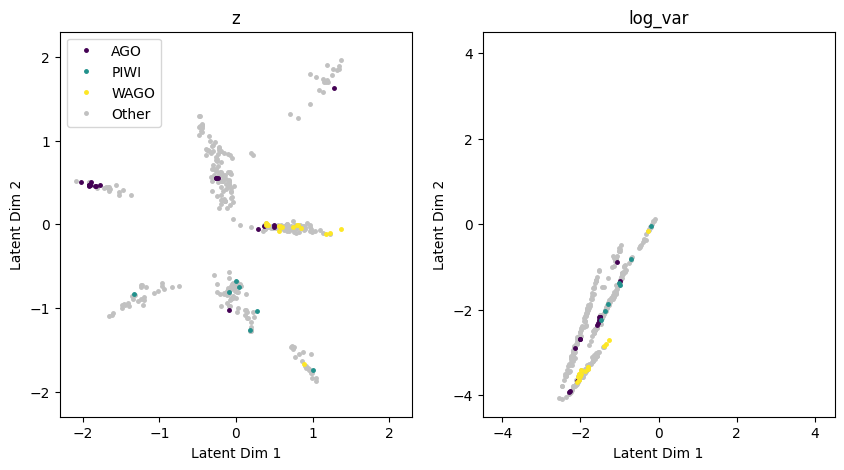

In [46]:
import matplotlib.pyplot as plt

vae_model.to('cuda')
vae_model.eval()

latents = []
vars = []
indices = []
labels = []

clade_labels = ['Other'] * len(id_labels)

true_ago_ids = [id for id, clade in id2clade.items() if clade == 'AGO']
true_wago_ids = [id for id, clade in id2clade.items() if clade == 'WAGO']
true_piwi_ids = [id for id, clade in id2clade.items() if clade == 'PIWI']

ago_indices = [id_labels.index(id) for id in true_ago_ids]
wago_indices = [id_labels.index(id) for id in true_wago_ids]
piwi_indices = [id_labels.index(id) for id in true_piwi_ids]

clade_indices = {'AGO': ago_indices, 'WAGO': wago_indices, 'PIWI': piwi_indices}
for clade, idx in clade_indices.items():
    for i in idx:
        clade_labels[i] = clade

classes = ['Other', 'AGO', 'PIWI', 'WAGO']
colors = [[193,193,193]] * 1 + [[68,1,84],[33,145,140],[253,231,37]]

colors = np.array(colors)/255.0

with torch.no_grad():
    for batch, idx in pdm.val_dataloader_indices():
        batch = batch.long().to('cuda')
        mu, log_var = vae_model.encode(batch)
        latents.append(mu)
        vars.append(log_var)
        indices.append(idx)

with torch.no_grad():
    for clade, idx in clade_indices.items():
        for batch in pdm.get_dataloader(idx):
            batch = batch.long().to('cuda')
            mu, log_var = vae_model.encode(batch)
            latents.append(mu)
            vars.append(log_var)
            indices.append(idx)

latents = torch.cat(latents).cpu().numpy()
vars = torch.cat(vars).cpu().numpy()
indices = np.concatenate(indices)  # indices in the original dataset
labels = [clade_labels[id] for id in indices]  # correspnding labels
class_lookup_table, class_idx = np.unique(labels, return_inverse=True)

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
handles = []
for i, embeddings in enumerate([latents, vars]):
    ax = axs[i]
    embedded_labels = class_idx
    for i in range(len(classes)):
        assert embeddings.shape[1] == 2
        try:
            class_index = list(class_lookup_table).index(classes[i])
        except:
            continue
        handle = ax.plot(embeddings[embedded_labels==class_index,0],
                         embeddings[embedded_labels==class_index,1],
                         '.', color=colors[i], label=classes[i], markersize=5) 
        handles += handle
    
    x_maxabs = np.max(np.abs(embeddings))*1.1
    y_maxabs = x_maxabs
    ax.set_xlim(-x_maxabs, x_maxabs)
    ax.set_ylim(-y_maxabs, y_maxabs)
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')

order = [1, 2, 3, 0]
axs[0].legend(handles=[handles[i] for i in order], labels=[classes[i] for i in order])

axs[0].set_title('z')
axs[1].set_title('log_var')

plt.show()

## Reconstruction & Logomaker

In [149]:
### Reconstruct the input sequence

target_id = 'H2KZD5'
recon_id = id_labels.index(target_id)

for batch in pdm.get_dataloader([recon_id]):
    batch = batch.long().to('cuda')
    x_recon, mu, log_var = vae_model.forward(batch)

L = dataset.shape[1]
C = NUM_CLASSES
x_recon = x_recon.view(L, C).detach().cpu()
# x_recon = x_recon.view(-1, C) # [N*L, C]

In [154]:
L = index_seqs_raw.shape[1]
C = NUM_CLASSES
filtered_positions = torch.where(gap_bools)[0]

x_recon_all = torch.zeros(L, C)
original_idx = 0
for idx in range(L):
    if idx not in filtered_positions:
        x_recon_all[idx] = x_recon[original_idx]
        original_idx += 1
    else:
        x_recon_all[idx, C-1] = 1

original_positions = torch.where(index_seqs_raw[recon_id] != GAP_INDEX)[0]
pssm_df = pd.DataFrame(x_recon_all, columns=list(AA_ALPHABETS))
pssm_df = pssm_df.loc[original_positions, :].reset_index(drop=True)

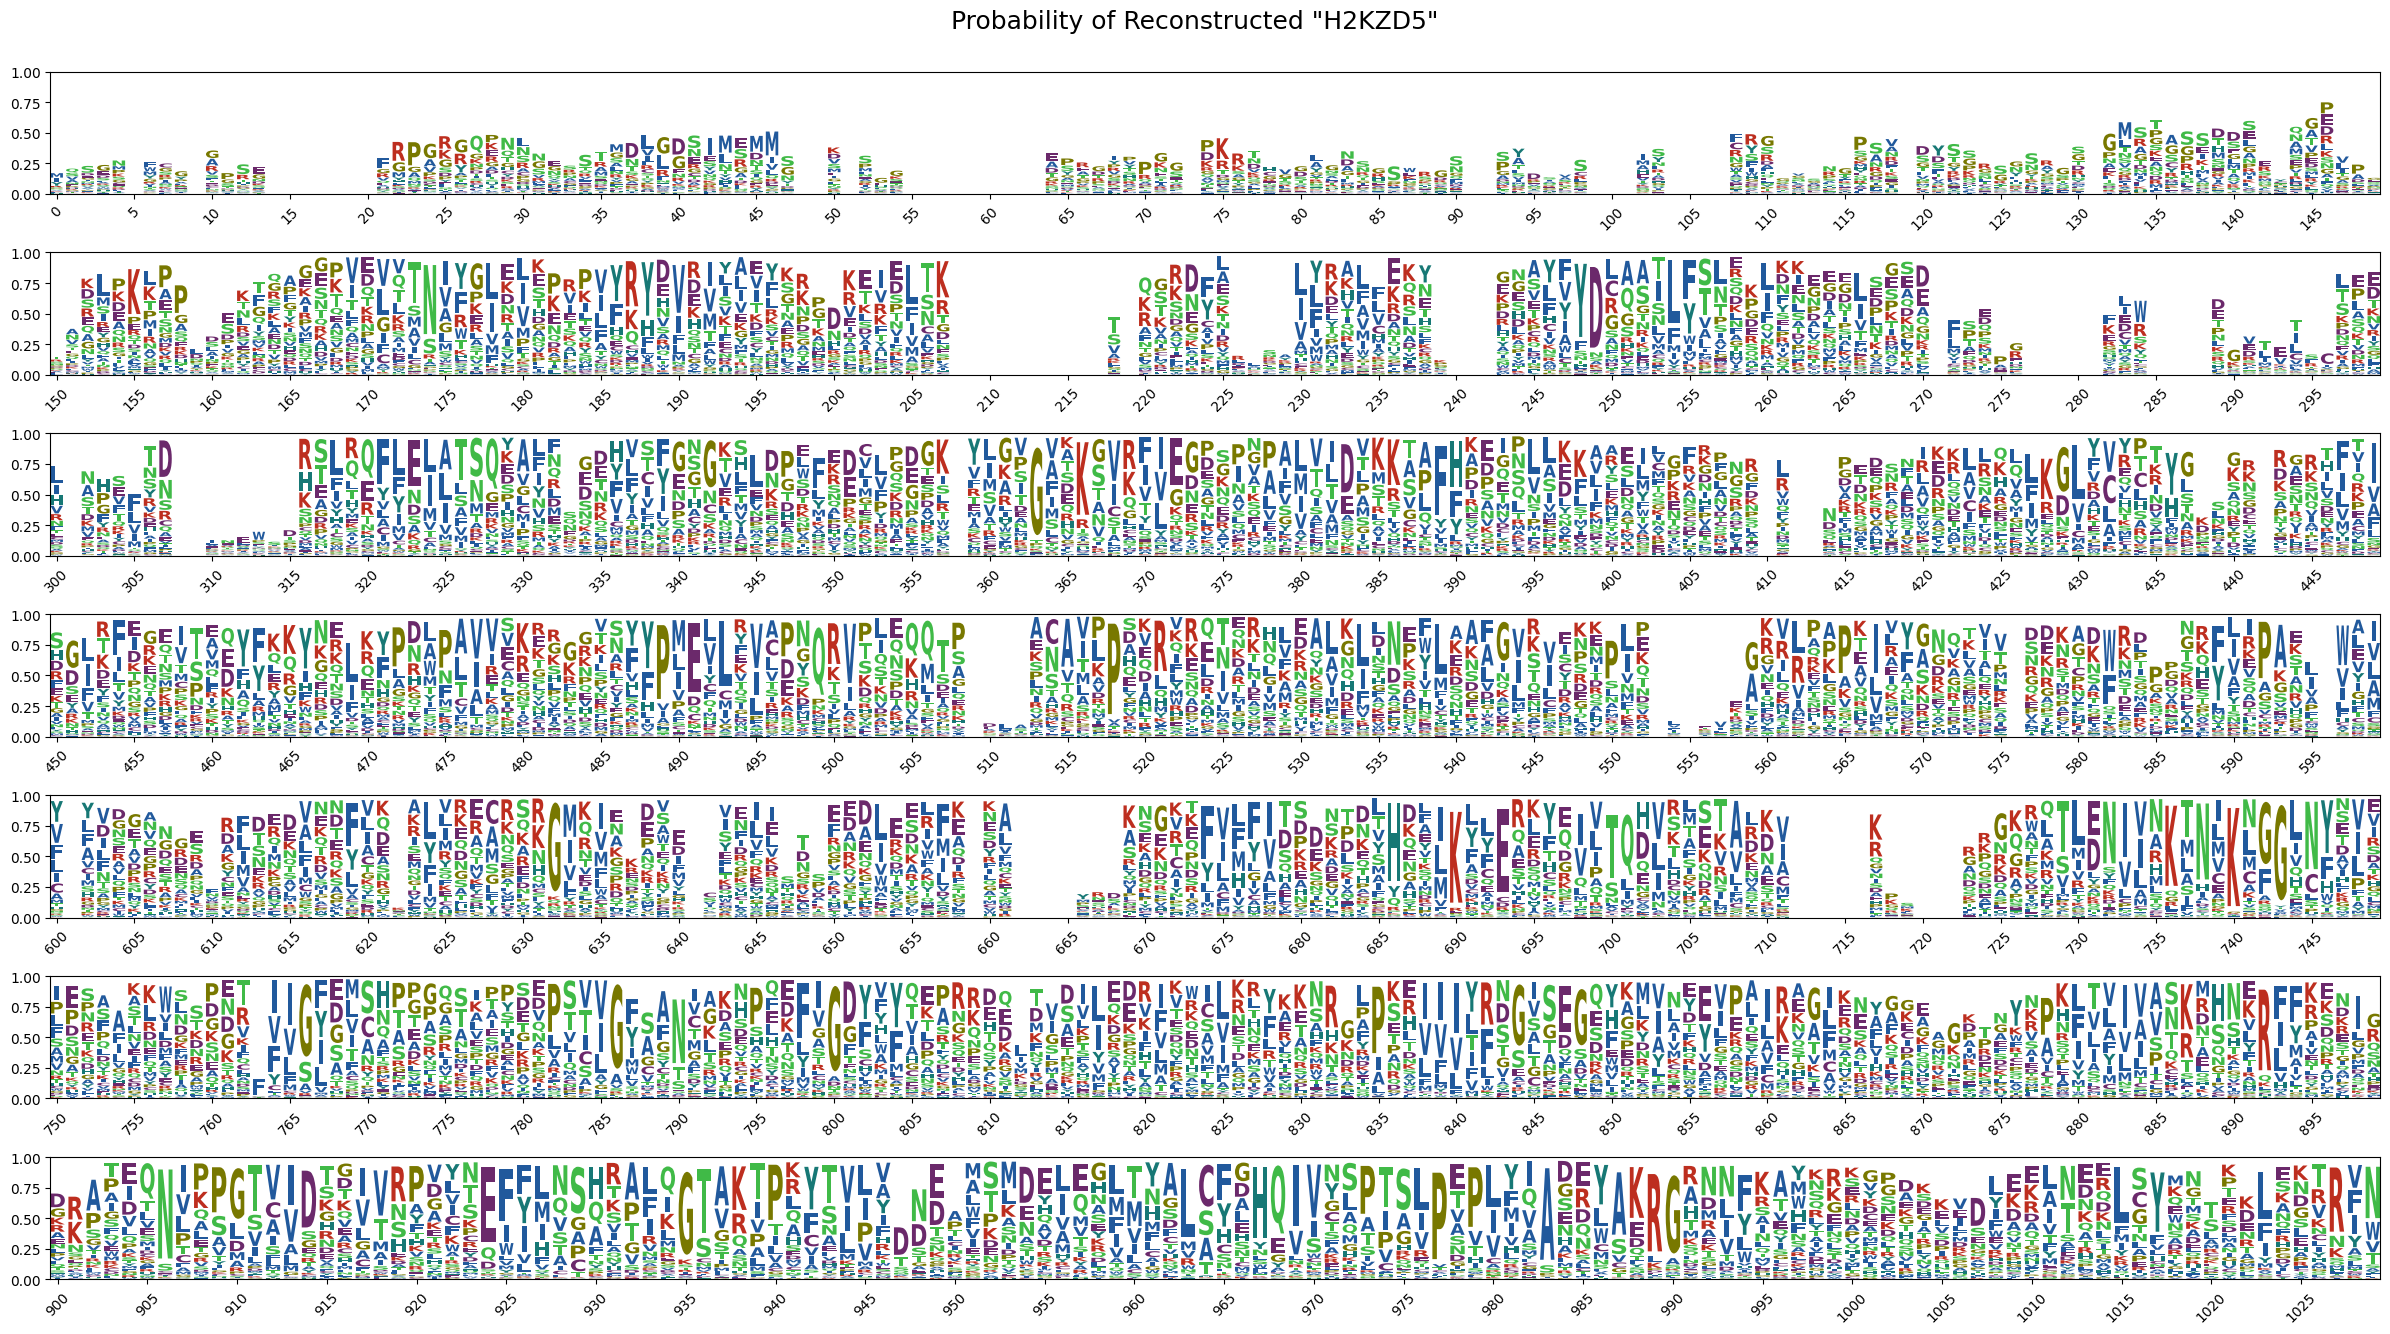

In [156]:
from pssm_analysis import plot_logomaker, calc_information_content

title = f'Probability of Reconstructed "{target_id}"'
plot_logomaker(pssm_df.iloc[:, 0:20], length_per_row=150, title=title, ylim=1)
# plt.savefig(f'/home/moon/projects/AgoAnalysis/VAE_Protein/outdir/recon_{target_id}.pssm_logo.png')
plt.show()

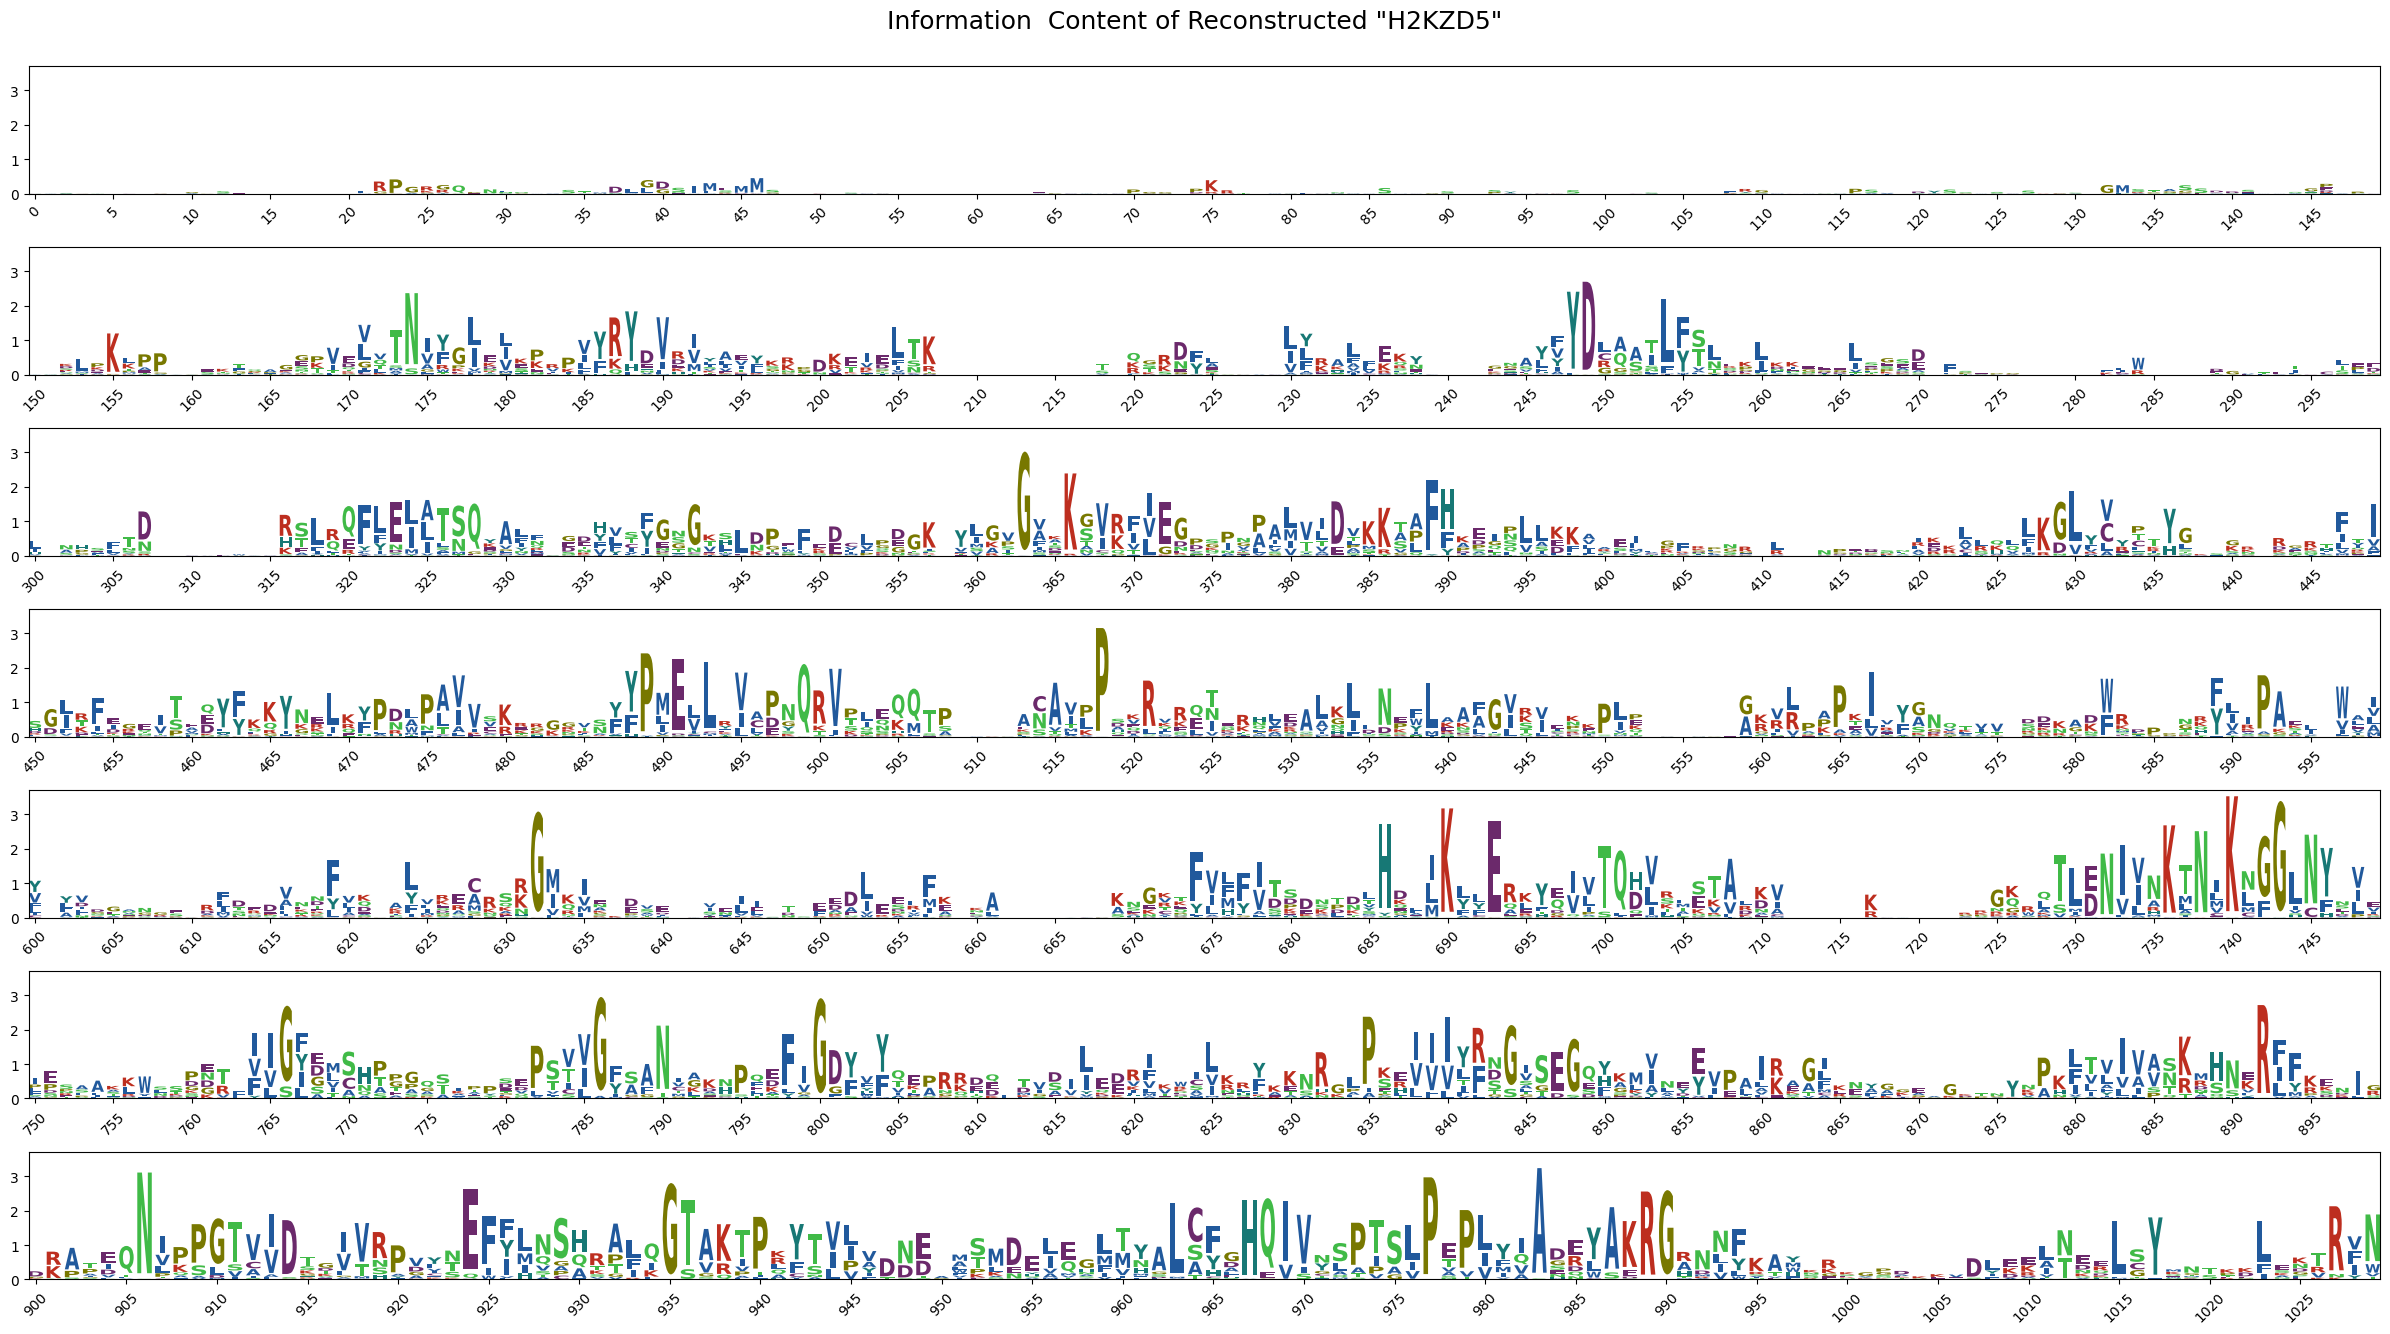

In [157]:
background_dict = {aa: 1/20 for aa in AA_ALPHABETS}
ic_df = calc_information_content(pssm_df, background_dict)
title = f'Information  Content of Reconstructed "{target_id}"'
plot_logomaker(ic_df.iloc[:, 0:20], length_per_row=150, title=title)
plt.savefig(f'/home/moon/projects/AgoAnalysis/VAE_Protein/outdir/vae_recon_{target_id}.info_logo.png')
plt.show()

In [ ]:
# all_indices = true_ago_ids + true_wago_ids + true_piwi_ids + leemor_ids

# vae_df = pd.DataFrame({
#     'id': all_indices,
#     'dim1': latents[:, 0],
#     'dim2': latents[:, 1],
#     'clade': labels})

# vae_df[(0 < vae_df.dim1) & (vae_df.dim1 < 1) & (0 < vae_df.dim2) & (vae_df.dim2 < 1)]